# 2-4. 降维

如前所述，单细胞RNA测序（scRNA-seq）是一种高通量测序技术，它产生的数据集在细胞和基因数量上都具有很高的维度。这立即指向了一个事实，即单细胞RNA测序数据受到了"维度诅咒"的困扰。

> **维度诅咒**
"维度诅咒"这个概念最早是由R. Bellman提出的，它描述的是理论上高维数据包含更多的信息，但在实践中并非如此。更高维度的数据往往包含更多的噪声和冗余，因此增加更多的信息并不利于后续的分析步骤。


并非所有的基因都具有信息性，或对于基于其表达谱进行细胞类型聚类的任务有重要意义。我们已经试图通过特征选择来降低数据的维度，作为下一步，人们可以通过使用降维算法来进一步降低单细胞RNA测序数据的维度。这些算法在预处理过程中是一个重要步骤，用于降低数据复杂性和进行可视化。已经开发并用于单细胞数据分析的降维技术有很多。



<img src="https://www.sc-best-practices.org/_images/dimensionality_reduction.jpeg" alt="Dimensionality reduction" class="bg-primary mb-1" width="800px">

降维将高维数据嵌入到低维空间中。低维表示仍然捕获数据的基本结构，同时尽可能少地具有维度。在这里，我们将三维对象可视化为投影到二维中。


Xing等人在独立比较中比较了10种不同的降维方法的稳定性，准确性和计算成本。他们建议使用t-分布随机邻居嵌入（t-SNE），因为它产生了最佳的整体性能。统一流形逼近和投影（UMAP）显示出最高的稳定性，并且最好地分离了原始细胞群体。在这种情况下，值得一提的另一种降维方法是主成分分析（PCA），它仍然被广泛使用。

一般来说，如果选择特定的初始化选项，t-SNE和UMAP非常稳健且大致相等.

所有上述方法都在`scanpy`与`omicverse`中实现。


In [1]:
import omicverse as ov
import scanpy as sc

ov.ov_plot_set()

In [2]:
adata = sc.read(
    filename="s4d8_preprocess.h5ad",
)

我们将使用数据集的归一化值表示进行降维和可视化，具体来说，就是使用计数矩阵的移位对数值。我们可以使用`adata.X.max()`检查计数矩阵的最大值来判断数据是否进行了移位对数计算

In [3]:
adata.X.max()

10.989398

我们从以下开始：

## 1. PCA

在我们的数据集中，每个细胞都是由某个正交基张成的 `n_var` 维向量空间中的一个向量。由于单细胞 RNA 测序(scRNA-seq)受到"维度的诅咒"的影响，我们知道并非所有的特征都对理解数据集的基础动态性有重要意义，且存在内在的冗余性。主成分分析（PCA）通过对原始数据集进行正交变换，创建一组新的无关变量，即所谓的主成分（PCs）。这些 PCs 是原始数据集中特征的线性组合，并按照方差的递减顺序进行排名以定义变换。通过排名，通常第一主成分的方差最大。最小方差的 PCs 被丢弃，有效地降低了数据的维度，同时不丧失信息。

PCA 的优点在于它具有高度的可解释性和计算效率。然而，由于单细胞 RNA 测序数据集由于掉落事件而相当稀疏，因此高度非线性，使用线性降维技术 PCA 进行可视化并不合适。但是我们可以基于PCA的结果再进行可视化。

这里需要介绍另一个重要的思想，z-score标准化，在机器学习中，特征缩放是一个重要的预处理步骤，通俗来说，使特征的标准差为 1，平均值为 0。经过z-score标准化后的数据对PCA降维有着显著影响，这在sklearn的官方教程中进行了测试：

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_scaling_importance_003.png" alt="Dimensionality reduction" class="bg-primary mb-1" width="800px">

从上图中我们观察到，先缩放特征再进行PCA降维可以使component具有相同的数量级。

在`omicverse`中，我们将scale后的值存放进`adata.layer`层，而不是像`scanpy`一样默认取代`.X`，缩放后的特征会移除基因间的差异，没有任何的证据表明，数据经过scale后会取得更好的分析结果，包括差异表达基因的计算等，若盲目地使用`scale`后的计数值，还可能会导致使用dotplot或者violinplot中忽略了基因自身的特征信息。

这听起来很难理解，事实上，比如我们关注的一个基因A的表达值在17-20区间，而基因B的表达值在0-3的区间，经过scale后，由于平均值被缩放成了0，基因A和基因B都在-2-2的区间范围内，这一定程度上失去了基因A表达量高的信息。故我们不认为对原始计数值进行`scale`是一个聪明的做法。

In [4]:
#我们首先选择高可变基因，并将原数据存放在.raw中
if adata.raw is None:
    adata.raw = adata.copy()
adata=adata[:,adata.var['highly_variable_features']==True]
adata.shape

(14814, 2000)

In [5]:
ov.pp.scale(adata,max_value=10)
adata

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'log1p'
    layers: 'counts', 'soupX_counts', 'scaled'

我们发现`adata`的layers层多出了一个`scaled`，这就是我们经过scale后的数据，接下来，我们基于scaled层进行pca

In [6]:
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'soupX_counts', 'scaled', 'lognorm'

我们再次观察发现，`adata.obsm`层里多出了一个`scaled|original|X_pca`，这代表了我们使用的是`layers`中的`scaled`层数据进行的pca计算，当然我们也可以使用`counts`进行pca计算，效果如下：

In [7]:
ov.pp.pca(adata,layer='counts',n_pcs=50)
adata

AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'counts|original|pca_var_ratios', 'counts|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'counts|original|X_pca'
    varm: 

我们可以使用embedding函数，来对比基于两种不同的layers计算所得出的pca的差异

<AxesSubplot: title={'center': 'MS4A1'}, xlabel='counts|original|X_pca1', ylabel='counts|original|X_pca2'>

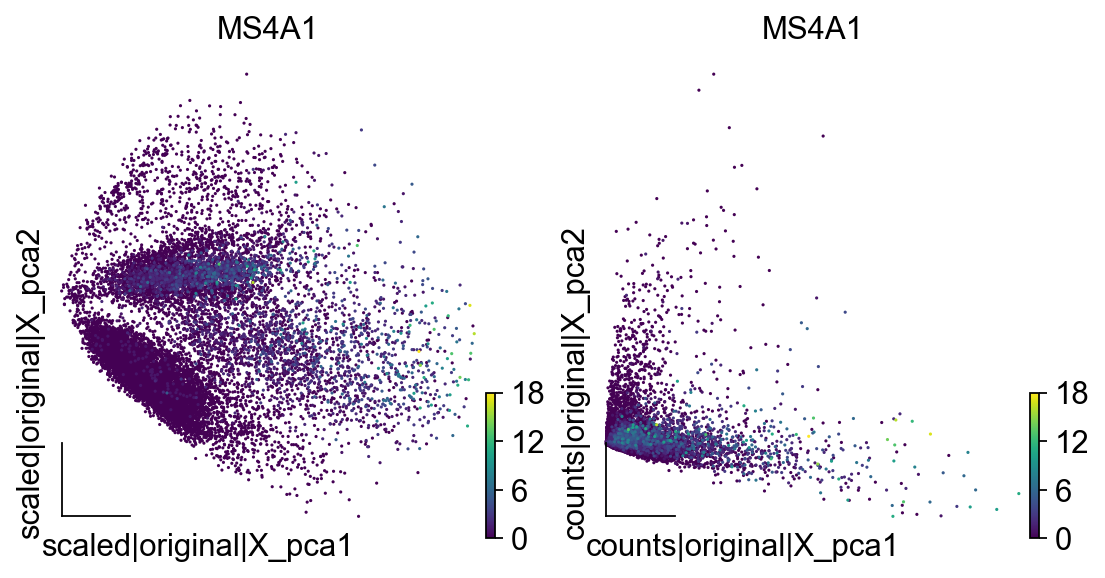

In [9]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,2,figsize=(8,4))
ov.utils.embedding(adata,
                basis='scaled|original|X_pca',frameon='small',
                color='MS4A1',show=False,ax=axes[0])
ov.utils.embedding(adata,
                basis='counts|original|X_pca',frameon='small',
                color='MS4A1',show=False,ax=axes[1])

我们会发现基于scaled的pca结果，第一主成分和第二主成分有着相似的数量级，而基于counts的pca结果，第一主成分和第二主成分的数量级则有所差异，这对于后续的2维投影可能会有显著的影响，我们在下面的教程中会进行对比分析。


## 2. t-SNE

t-SNE 是一种基于图的、非线性的降维技术，它将高维数据投影到 2D 或 3D 组件上。该方法基于数据点之间的高维欧几里得距离定义了一个高斯概率分布。随后，使用 t 分布在低维空间中重建概率分布，其中嵌入通过梯度下降进行优化。

In [10]:
sc.tl.tsne(adata, use_rep="scaled|original|X_pca")
#tsne函数默认是存放在adata.obsm['X_tsne']中的，我们将其存放在adata.obsm['X_tsne_scaled']中来区分counts的结果
adata.obsm['X_tsne_scaled']=adata.obsm['X_tsne']
sc.tl.tsne(adata, use_rep="counts|original|X_pca")
adata.obsm['X_tsne_counts']=adata.obsm['X_tsne']
adata

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:35)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:46)


AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'counts|original|pca_var_ratios', 'counts|original|cum_sum_eigenvalues', 'tsne'
    obsm: 'scaled|original|X_pca', 'counts|original|X_pca', '

<AxesSubplot: title={'center': 'MS4A1'}, xlabel='X_tsne_counts1', ylabel='X_tsne_counts2'>

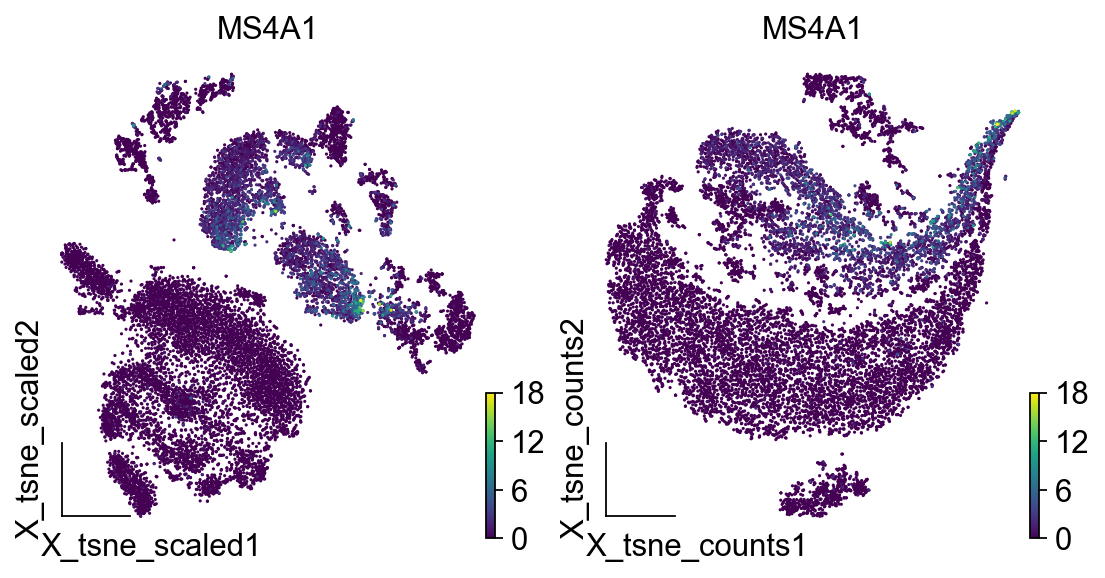

In [11]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,2,figsize=(8,4))
ov.utils.embedding(adata,
                basis='X_tsne_scaled',frameon='small',
                color='MS4A1',show=False,ax=axes[0])
ov.utils.embedding(adata,
                basis='X_tsne_counts',frameon='small',
                color='MS4A1',show=False,ax=axes[1])

## 3.UMAP

UMAP 是一种基于图的、非线性的降维技术，原理上与 t-SNE 类似。它构建了数据集的高维图表示，并优化低维图表示，使其在结构上尽可能地与原始图相似。

我们首先基于PCA的结果，在单细胞数据上构建一个邻域图

In [12]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
sc.tl.umap(adata)
#umap函数默认是存放在adata.obsm['X_umap']中的，我们将其存放在adata.obsm['X_umap_scaled']中来区分counts的结果
adata.obsm['X_umap_scaled']=adata.obsm['X_umap']

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='counts|original|X_pca')
sc.tl.umap(adata)
adata.obsm['X_umap_counts']=adata.obsm['X_umap']

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


<AxesSubplot: title={'center': 'MS4A1'}, xlabel='X_umap_counts1', ylabel='X_umap_counts2'>

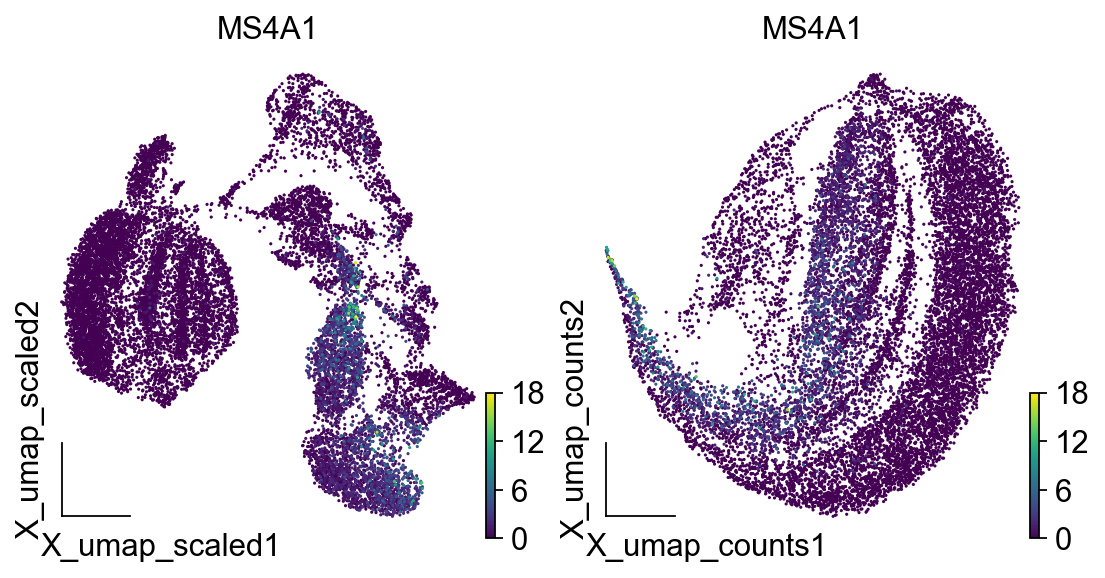

In [13]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,2,figsize=(8,4))
ov.utils.embedding(adata,
                basis='X_umap_scaled',frameon='small',
                color='MS4A1',show=False,ax=axes[0])
ov.utils.embedding(adata,
                basis='X_umap_counts',frameon='small',
                color='MS4A1',show=False,ax=axes[1])

我们发现基于counts的pca无法构建出合理的细胞分布，MS4A1是B细胞的marker基因，这一定程度上证实了scale对于pca的重要性。除此之外，如果你的电脑有GPU，那么可以尝试使用mde来绘制UMAP图，pymde包是GPU加速的UMAP绘图函数。mde函数内自带neighbor的计算，所以我们可以直接输入pca结果

In [14]:
adata.obsm["X_mde_scaled"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata.obsm["X_mde_counts"] = ov.utils.mde(adata.obsm["counts|original|X_pca"])

<AxesSubplot: title={'center': 'MS4A1'}, xlabel='X_mde_counts1', ylabel='X_mde_counts2'>

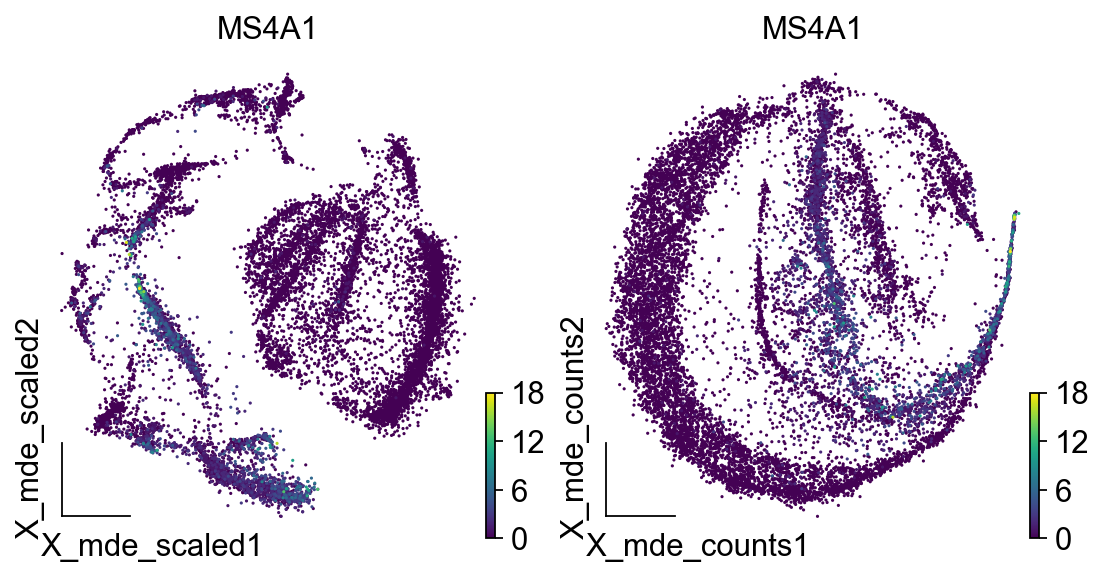

In [15]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(1,2,figsize=(8,4))
ov.utils.embedding(adata,
                basis='X_mde_scaled',frameon='small',
                color='MS4A1',show=False,ax=axes[0])
ov.utils.embedding(adata,
                basis='X_mde_counts',frameon='small',
                color='MS4A1',show=False,ax=axes[1])

## 4.检查质量控制指标

现在我们也可以在我们之前计算的 PCA、TSNE 或 UMAP 图中检查我们之前计算的质量控制指标，并识别出潜在的低质量的细胞。在论文中，我们一般会检查三个指标，nUMI计数，nGene计数，以及线粒体基因的比例。这里再重复一次，nUMI是基因数加上每个基因的数量，nGene代表的是基因的种类。

如果你前面使用的是`omicverse.pp.qc`，那么你将直接得到nUMIs，detected_genes，mito_perc三个变量，如果你使用的是`scanpy`进行的qc，那么你得到的将是total_counts,n_genes_by_counts, 和pct_counts_mt三个变量，我们再2-1的教程中对比过三个变量的值发现是一样的，只是不同的包给出的名字不同。

我们使用numpy中的log2对数化，将数据可视化区间缩小，同时，我们定义最大最小值来衡量我们的数据质量，我们希望nUMIs大于250，250的对数值是7.96，所以我们最小值设定为8，最大值则定义为30,000，即15，而线粒体的比例则在0-100的范围内。

[<AxesSubplot: title={'center': 'log2#(nUMIs)'}, xlabel='X_mde_scaled1', ylabel='X_mde_scaled2'>,
 <AxesSubplot: title={'center': 'log2#(nGenes)'}, xlabel='X_mde_scaled1', ylabel='X_mde_scaled2'>,
 <AxesSubplot: title={'center': 'Mito_Perc'}, xlabel='X_mde_scaled1', ylabel='X_mde_scaled2'>]

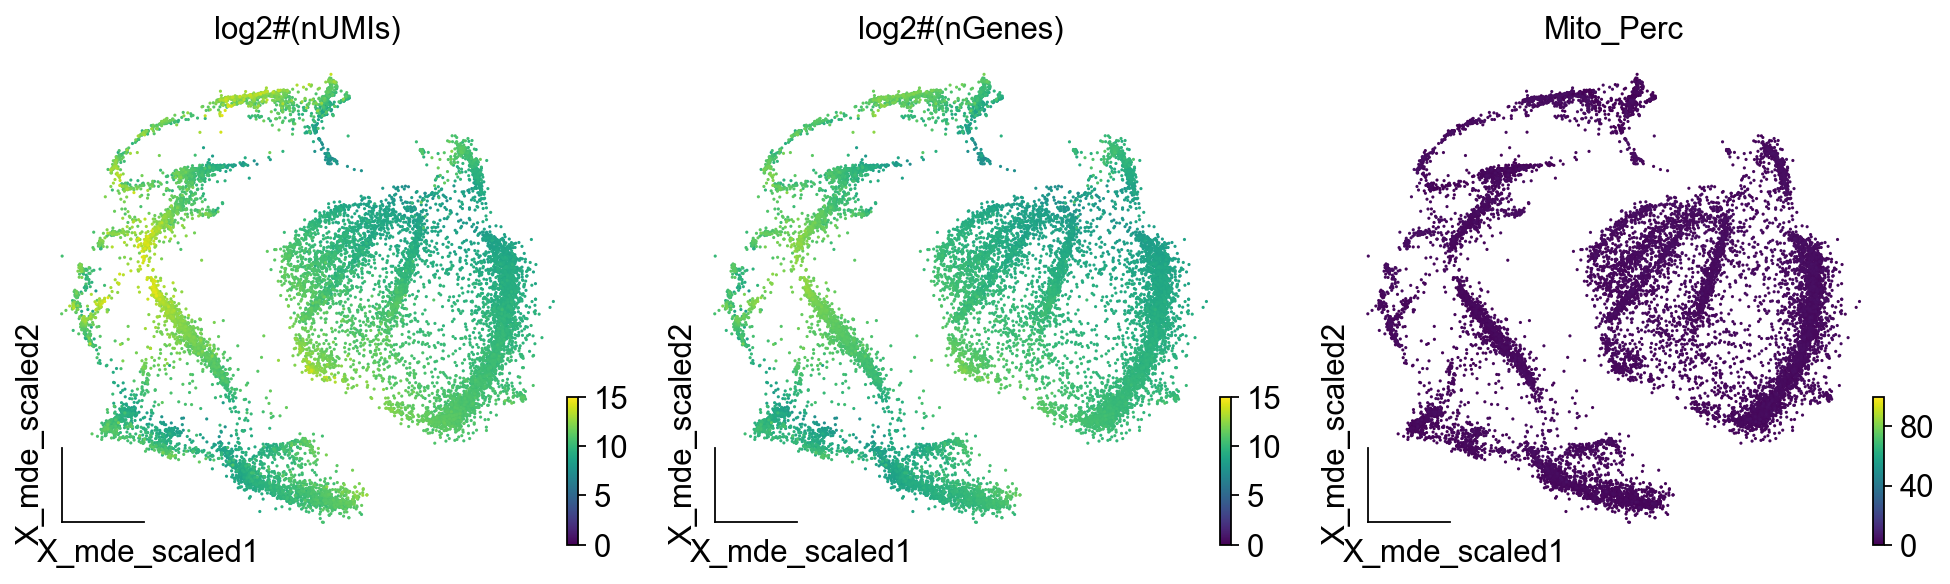

In [16]:
import numpy as np
adata.obs['log2_nUMIs']=np.log2(adata.obs['total_counts'])
adata.obs['log2_nGenes']=np.log2(adata.obs['n_genes_by_counts'])
ov.utils.embedding(adata,
                basis='X_mde_scaled',
                color=['log2_nUMIs','log2_nGenes','pct_counts_mt'],
                title=['log2#(nUMIs)','log2#(nGenes)','Mito_Perc'],
                vmin=[0,0,0],
                vmax=[15,15,100],show=False,frameon='small',)

我们发现数据的质量较好，这三幅图即是单细胞质控所用到的基本三幅图，此外，对于特定的任务，我们还会衡量细胞周期基因，详细的计算可参考`scanpy`中的教程。